# Search for HLS data using `pystac_client`

### For debugging HLS querying from LPDAAC STAC

In [24]:
pip install cogeo_mosaic

  Using cached cogeo_mosaic-8.2.0-py3-none-any.whl.metadata (19 kB)
  Using cached pydantic_settings-2.9.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached supermorecado-0.1.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached typing_inspection-0.4.0-py3-none-any.whl.metadata (2.6 kB)
Using cached cogeo_mosaic-8.2.0-py3-none-any.whl (40 kB)
Using cached pydantic_settings-2.9.1-py3-none-any.whl (44 kB)
Using cached supermorecado-0.1.2-py3-none-any.whl (14 kB)
Using cached typing_inspection-0.4.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import fetch_HLS
import plotlib
from mosaiclib import *

## Tests

### NOTE:
if `cogeo_mosaic` has been installed, it bring with it the newest `rio_tiler` which will break this script.  
You want `rio_tiler==6.6.1`

In [2]:
import CovariateUtils

In [3]:
import geopandas as gpd
from mosaiclib import *

In [4]:
import rio_tiler

In [5]:
rio_tiler.__version__

'7.2.2'

## Wrap `build_ms_composite.py` for testing

In [6]:
#pip install --force-reinstall -v "rio_tiler==6.6.1"

In [80]:
# Landsat Collection 2 SR
SAT_API = 'https://landsatlook.usgs.gov/stac-server'
MS_COMP_TYPE = 'LC2SR'

# HLS
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
MS_COMP_TYPE = 'HLS'

def wrapper_composite(params):

    FOCAL_TILE = params.get('FOCAL_TILE')
    SAT_API = params.get('SAT_API')
    MS_COMP_TYPE = params.get('MS_COMP_TYPE')
    YEAR = params.get('YEAR')
    MIN_N_FILT_RESULTS = params.get('MIN_N_FILT_RESULTS')
    SEASON_START = params.get('SEASON_START')
    SEASON_STOP = params.get('SEASON_STOP')
    INDEX_FN = params.get('INDEX_FN')
    INDEX_LYR = params.get('INDEX_LYR')
    STAT = params.get('STAT')
    STAT_PCT = params.get('STAT_PCT')

    INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg'
    INDEX_LYR = 'boreal_tiles_v004'
    YEAR_START, YEAR_STOP = (YEAR, YEAR)
    HLS_PRODUCT = 'H30'
    MAX_CLOUDS = 0

    OUTDIR = '/projects/my-private-bucket/tmp'
    
    args = f"-i {INDEX_FN} \
        -lyr {INDEX_LYR} \
        -a {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {FOCAL_TILE} \
        -o {OUTDIR} \
        -sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} \
        --composite_type {MS_COMP_TYPE} \
        --hls_product {HLS_PRODUCT} \
        --rangelims_red -10 10 \
        --thresh_min_ndvi -1 \
        --min_n_filt_results {MIN_N_FILT_RESULTS} \
        --stat {STAT} \
        --stat_pct {STAT_PCT}"
    #args += " --do_indices"
    #args += " --search_only"
    
    cmd = f'python /projects/code/icesat2_boreal/lib/build_ms_composite.py {args}'
    #!echo $cmd
    !eval $cmd

    fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}.tif'
    if STAT == 'percentile':
        fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}{STAT_PCT}.tif'
    # rescaled_multiband_fn = os.path.join(os.path.dirname(fn), os.path.basename(fn).replace('.tif','_rescaled_3band_temp.tif'))
    # plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [5,7,3], pct=[20,90], nodata=-9999.0) 

    return fn

### Test Build MS Composite (new version of 3.1.2)

TODO:  
+ Fix 0 values coming out of comp when a pixel slice is all NaN. Need this to be NaN.
+ adjust red_rangelims : change for winter comps; are they even needed in any comps?
+ adjust min ndvi thresh
+ test for tiles with ocean
+ test for Landsat 5/7 comps

In [105]:
args_dict_septoct = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2024, 
    'MIN_N_FILT_RESULTS': 50,
    'SEASON_START': '09-01',
    'SEASON_STOP': '10-31',
}
args_dict_julyaug = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2013, 
    'MIN_N_FILT_RESULTS': 50,
    'SEASON_START': '07-01',
    'SEASON_STOP': '08-31',
}
args_dict_marchapril = {
    'SAT_API': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 
    'MS_COMP_TYPE': 'HLS',
    'YEAR': 2024, 
    'MIN_N_FILT_RESULTS': 50,
    'SEASON_START': '03-01',
    'SEASON_STOP': '04-30',
}

In [95]:
'_'.join(['HLS' , str(938) , '03-01' , '04-30' , '2024' , '2024' , 'max' ,'.tif'])

'HLS_938_03-01_04-30_2024_2024_max_.tif'

In [ ]:
%%time
params = args_dict_julyaug.copy()
params['FOCAL_TILE'] = 37743 #936
params['STAT'] = 'max'
params['STAT_PCT'] = 50.0

fn = wrapper_composite(params)


Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 37743
Output res (m):		 30
in_bbox:		 [-2151478.0000000047, 4923304.000000009, -2061478.0000000047, 5013304.000000009]
bbox 4326:		 [101.06339684573825, 71.7769772758511, 104.52417823212295, 72.85675979790454]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 3000
Composite type:		HLS

Getting HLS Surface Reflectance H30 data...
bbox: [101.06339684573825, 71.7769772758511, 104.52417823212295, 72.85675979790454]

Querying STAC for multispectral imagery...
Catalog title: LPCLOUD STAC Catalog
start date, end date:		 2013-07-01T00:00:00Z 2013-08-31T23:59:59Z

Conducting multispectral image search now ...
Searching for:			['HLSL30_2.0', 'HLSS30_2.0']
Max cloudcover threshold starts at: 0% and won't exceed 90%
Min number of filtered results: 50
partial results (HLSL30_2.0):				11
partial results (HLSS30_2.0):				0
	Only 11 HLS 

In [70]:
import plotlib
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3000, 'height': 3000, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -2151478.0000000047,
       0.0, -30.0, 5013304.000000009), 'blockxsize': 3000, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


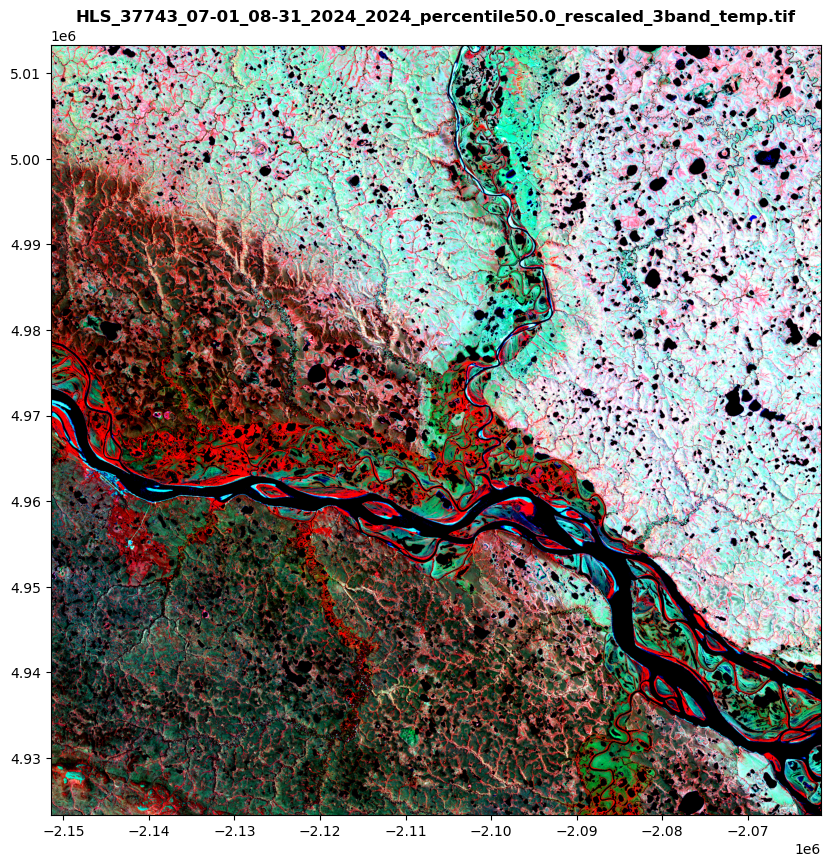

In [103]:
#fn = '/projects/my-private-bucket/tmp/LC2SR_3458_07-01_07-30_2000_2000_max.tif'
fn = '/projects/my-private-bucket/tmp/HLS_37743_07-01_08-31_2024_2024_percentile50.0.tif'
#fn = '/projects/my-private-bucket/tmp/HLS_37743_07-01_08-31_2024_2024_max.tif'
# fn = '/projects/my-private-bucket/tmp/HLS_37743_09-01_10-31_2024_2024_max.tif'
# fn = '/projects/my-private-bucket/tmp/HLS_37743_09-01_10-31_2024_2024_percentile50.0.tif'
rescaled_multiband_fn = fn.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [4,6,3], pct=[20,90], nodata=-9999.0) 

fig,ax=plt.subplots(figsize=(10,10))
with rasterio.open(rescaled_multiband_fn) as src:
    print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3000, 'height': 3000, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 1448521.9999999953,
       0.0, -30.0, 3123304.0000000093), 'blockxsize': 3000, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


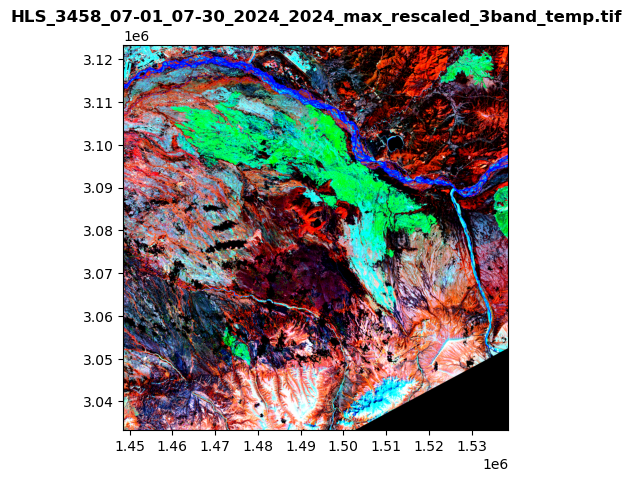

In [37]:
fn = '/projects/my-private-bucket/tmp/HLS_3458_07-01_07-30_2024_2024_max.tif'
rescaled_multiband_fn = fn.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [4,6,3], pct=[20,90], nodata=-9999.0) 

fig,ax=plt.subplots(figsize=(5,5))
with rasterio.open(rescaled_multiband_fn) as src:
    print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))

### Test for Landsat C2 SR

In [180]:
%%time
fn = wrapper_composite('https://landsatlook.usgs.gov/stac-server', 'LC2SR', FOCAL_TILE,
                       2000, MIN_N_FILT_RESULTS = MIN_N_FILT_RESULTS, SEASON_START = SEASON_START, SEASON_STOP = SEASON_STOP,
                        STAT = 'percentile', STAT_PCT = 90)


Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30
in_bbox:		 [1448521.9999999953, 3033304.0000000093, 1538521.9999999953, 3123304.0000000093]
bbox 4326:		 [-148.68403258941558, 63.78962125560303, -146.1345823219171, 64.86503792887652]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 3000
Composite type:		LC2SR

Getting Landsat Collection 2 Surface Reflectance (landsat-c2l2-sr) data...
bbox: [-148.68403258941558, 63.78962125560303, -146.1345823219171, 64.86503792887652]

Querying STAC for multispectral imagery...
Catalog title: STAC API
start date, end date:		 2000-07-01T00:00:00Z 2000-07-30T23:59:59Z

Conducting multispectral image search now ...
Searching for:			['landsat-c2l2-sr']
Max cloudcover threshold starts at: 0% and won't exceed 90%
Min number of filtered results: 25
partial results (landsat-c2l2-sr):				0
	Only 0 HLS scenes using lte 

### Test 3.1.2

In [148]:
INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg'
INDEX_LYR = 'boreal_tiles_v004'
#SAT_API = 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD' 
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
OUTDIR = '/projects/my-private-bucket/tmp'
YEAR = 2024
MS_DATA_TYPE = 'HLS'

def wrapper_312(SAT_API, MS_COMP_TYPE, FOCAL_TILE, YEAR, 
                        MIN_N_FILT_RESULTS = 10,
                        SEASON_START = '07-01',
                        SEASON_STOP = '08-31',
                      INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
                      INDEX_LYR = 'boreal_tiles_v004'
                     ):
    HLS_PRODUCT = 'H30'
    YEAR_START = YEAR
    YEAR_STOP = YEAR 
    MAX_CLOUDS = 0

    OUTDIR = '/projects/my-private-bucket/tmp'

    args = f"-i {INDEX_FN} \
        -lyr {INDEX_LYR} \
        -a {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {FOCAL_TILE} \
        -o {OUTDIR} \
        -sy {YEAR} -ey {YEAR} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} \
    --composite_type {MS_COMP_TYPE} \
    --hls_product {HLS_PRODUCT} \
    --rangelims_red 0 1 \
    --thresh_min_ndvi -1 \
    --min_n_filt_results {MIN_N_FILT_RESULTS}"
    
    #args += " --search_only"
    
    cmd = f'python /projects/code/icesat2_boreal/lib/3.1.2_dps.py {args}'
    !echo $cmd
    !eval $cmd

    # Create a stretched image
    fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}.tif'

    return fn

In [149]:
fn = wrapper_312('https://cmr.earthdata.nasa.gov/stac/LPCLOUD', 'HLS', FOCAL_TILE, YEAR, MIN_N_FILT_RESULTS = MIN_N_FILT_RESULTS, SEASON_START = SEASON_START, SEASON_STOP = SEASON_STOP)

python /projects/code/icesat2_boreal/lib/3.1.2_dps.py -i https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg -lyr boreal_tiles_v004 -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --in_tile_num 3813 -o /projects/my-private-bucket/tmp -sy 2024 -ey 2024 -smd 07-01 -emd 07-30 -mc 0 --composite_type HLS --hls_product H30 --rangelims_red 0 1 --thresh_min_ndvi -1 --min_n_filt_results 3

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3813
Output res (m):		 30
in_bbox:		 [-981478.0000000047, 2673304.0000000093, -891478.0000000047, 2763304.0000000093]
bbox 4326:		 [159.7024966920305, 62.72785123262745, 161.95670835785344, 63.71505400641204]
Getting output dims from buffered (buffer=0.0) original tile geometry...
Output dims:		3000 x 3000
Composite type:		HLS

Getting HLS Surface Reflectance H30 data...
bbox: [159.7024966920305, 62.72785123262745, 161.9567083578534

### Do some multiprocessing with a list to test `tiles`, `years`, and `seasonal windows`

In [35]:
from multiprocessing import Pool
from functools import partial

In [60]:
# YEAR_LIST = [str(x) for x in range(1984,2024+5,5)]
YEAR_LIST = [2013, 2024]
FOCAL_TILE_LIST = [37743,3458,3813,3733]

In [61]:
params_list = []
for YEAR in YEAR_LIST:
    for FOCAL_TILE in FOCAL_TILE_LIST:
        
        d1 = args_dict_marchapril.copy()
        d2 = args_dict_julyaug.copy()
        d3 = args_dict_septoct.copy()

        for d in [d1, d2, d3]:
            d['YEAR'] = YEAR
            d['FOCAL_TILE'] = FOCAL_TILE
            d['STAT'] = 'percentile'
            d['STAT_PCT'] = 50
            params_list += [d]   

In [62]:
len(params_list)

6

In [ ]:
with Pool(processes=6) as pool:
    pool.map(wrapper_composite, params_list)


Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30

Tiles path:		 https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg
Tile number:		 3458
Output res (m):		 30
in_bbox:		 [1448521.9999999953, 3033304.0000000093, 1538521.9999999953, 3123304.0000000093]
bbox 4326:		 [

In [38]:
# with Pool(processes=3) as pool:
#     pool.map(partial(wrapper_composite, **args_dict, STAT='percentile', STAT_PCT=50), FOCAL_TILE_LIST)